In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.9.1'

In [3]:
def set_gpu(gpu_index):
    import tensorflow as tf
    physical_devices  = tf.config.experimental.list_physical_devices('GPU')
    print(f'Available GPUs: {len(physical_devices )}')
    if physical_devices:
        print(f'Choosing GPU #{gpu_index}')
        try:
            tf.config.experimental.set_visible_devices([physical_devices[gpu_index]], 'GPU')
            logical_devices = tf.config.list_logical_devices('GPU')
            assert len(logical_devices) == 1
            print(f'Success. Now visible GPUs: {len(logical_devices)}')
        except RuntimeError as e:
            print('Something went wrong!')
            print(e)

In [4]:
set_gpu(0)

Available GPUs: 1
Choosing GPU #0
Success. Now visible GPUs: 1


In [5]:
import os
import numpy as np
import cv2
from skimage.io import imread, imsave
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

**Define the model**

In [6]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers.pooling import GlobalAveragePooling2D

In [7]:
class HistClassificationModel:

    def __init__(self):

        base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                       include_top=False,
                                                       weights='imagenet')
        base_model.trainable = False

        inputs = Input((224, 224, 3))
        x = base_model(inputs, training=False)
        x = GlobalAveragePooling2D()(x)
        logits = Dense(5, activation=None)(x)
        self.model = Model(inputs, outputs=[x, logits])

        self.model.compile(
            optimizer=Adam(learning_rate=0.000002), 
            loss='categorical_crossentropy',
            metrics=['accuracy'],
        )

        self.model.summary()
        
    def load_weights(self, path_ckpt):
        self.model.load_weights(path_ckpt)

In [8]:
net = HistClassificationModel()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 tf.math.reduce_mean (TFOpLa  (None, 1024)             0         
 mbda)                                                           
                                                                 
 dense (Dense)               (None, 5)                 5125      
                                                                 
Total params: 7,042,629
Trainable params: 5,125
Non-trainable params: 7,037,504
_________________________________________________________________


**Load pre-trained ckpts**

In [9]:
net.load_weights(r"C:\Users\penki\Documents\cmc\ScaleEstimation\ckpt\densenet121_wsi224\model_best.hdf5")

**Get evaluation dataset**

NOTE:

предложенная Александром Хвостиковым модель DenseNet121 обучена летом 2022 на слегка другой выборке из
набора данных `PATH-DT-MSU-WSI`.

Тренировочный сет имел гораздо меньший размер.

Валидационные патчи (`./data/patches_new_6/test-224-z20`) были просэмплированы из всего двух полнослайдовых изображений:
- `c:\\dev\\#data\\PATH-DT-MSU-WSI\\S2\\S2\\06.svs`
- `c:\\dev\\#data\\PATH-DT-MSU-WSI\\S2\\S2\\08.svs`

В ноябре 2022 датасет доразметили, однако модель переобучить не успели.

Точность модели на `patches-wsi-224-val-z2`:
- Accuracy: 0.684
- Balanced accuracy: 0.561
- Confusion matrix:

In [ ]:
print(np.array([[4508,      90,    16,   2037,   114],

                [1357,   12105,   218,    239,   181],

                [13,         1,   420,      0,   139],

                [108,        0,     9,     66,     0],

                [1942,       2,   219,   1605,   875]]))

In [ ]:
from image_tfdatasets import PATH_DT_MSU_WSI

In [10]:
BATCH_SIZE = 32
H = 224
W = 224
C = 3

In [ ]:
val_db = PATH_DT_MSU_WSI(db_list=r"C:\Users\penki\Documents\cmc\data\PATH-DT-MSU-WSI\val.txt",
                         db_folder_to_label_list=r"C:\Users\penki\Documents\cmc\data\PATH-DT-MSU-WSI\folder_to_label.json",
                         db_basedir=r"C:\Users\penki\Documents\cmc\data\PATH-DT-MSU-WSI\patches-wsi-224-val-z2",
                         dtype_in=tf.uint8,
                         shuffle=False)
val_db_tf = val_db.get_tfdataset(with_label=True, batch_size=BATCH_SIZE)

In [ ]:
num_batches = len(val_db) // BATCH_SIZE

**Evaluate mode with pre-trained weights on the original scale**

In [ ]:
from evaluator import Image2LabelEvaluator as Evaluator

In [ ]:
print("[*] Benchmarking on testing set...")
evaluate_engine = Evaluator(net.model,
                            val_db_tf.take(num_batches),
                            num_batches)
top1, top5, ce = evaluate_engine()
print("Top-1: {0:.4f}; Top-5: {1:.4f}; Cross-Entropy: {2:.4f}".format(top1, top5, ce))
print("Done.\n")

# {
#     "top-1": float(top1.numpy()),
#     "top-5": float(top5.numpy()),
#     "cross-entropy": float(ce.numpy())
# }

**Testing on real multi-scale WSI via OpenSlide library**

In [11]:
# The path can also be read from a config file, etc.
OPENSLIDE_PATH = r'C:\tools\openslide-win64-20221217\bin'

import os
if hasattr(os, 'add_dll_directory'):
    # Python >= 3.8 on Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide
    
# import large_image

from openslide import open_slide
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [12]:
import os

import numpy as np
import matplotlib.pyplot as plt

In [13]:
DEF_COLOR_MAP = {
    0: (245, 119, 34), # AT (orange)
    1: (153, 255, 255), # BG (cyan)
    2: (64, 170, 72), # LP (green)
    3: (255, 0, 0), # MM (red)
    4: (33, 67, 156), # TUM (blue)
}

DEF_COLOR_MAP_NAME = {
    0: "orange", # AT (orange)
    1: "cyan", # BG (cyan)
    2: "green", # LP (green)
    3: "red", # MM (red)
    4: "blue", # TUM (blue)
}

DEF_STYLE_MAP_NAME = {
    0: "-", # AT (orange)
    1: ":", # BG (cyan)
    2: "-.", # LP (green)
    3: (0, (3, 1, 1, 1, 1, 1)), # MM (red)
    4: "--", # TUM (blue)
}

DEF_LABEL_FOLDER = {
    0: "AT", # AT (orange)
    1: "BG", # BG (cyan)
    2: "LP", # LP (green)
    3: "MM", # MM (red)
    4: "TUM", # TUM (blue)
}

In [14]:
wsi_path = r"C:\Users\penki\Documents\cmc\data\PATH-DT-MSU-WSI\WSS2-v1\train\03.svs"

In [15]:
slide = open_slide(wsi_path)

In [16]:
slide.properties

<_PropertyMap {'aperio.AppMag': '40', 'aperio.Date': '11/06/20', 'aperio.DisplayColor': '0', 'aperio.Exposure Scale': '0.000001', 'aperio.Exposure Time': '45', 'aperio.Filename': '1043324', 'aperio.Focus Offset': '-0.000500', 'aperio.ICC Profile': 'AT2', 'aperio.ImageID': '1043324', 'aperio.Left': '23.844707', 'aperio.LineAreaXOffset': '0.016146', 'aperio.LineAreaYOffset': '0.001517', 'aperio.LineCameraSkew': '-0.002095', 'aperio.MPP': '0.2528', 'aperio.OriginalHeight': '65909', 'aperio.OriginalWidth': '101600', 'aperio.ScanScope ID': 'SS7315', 'aperio.SessonMode': 'NR', 'aperio.StripeWidth': '2032', 'aperio.Time': '14:51:24', 'aperio.Time Zone': 'GMT+03:00', 'aperio.Top': '19.264688', 'aperio.User': 'a8d3f0e3-63d8-4f23-a277-b4bfcf02ca71', 'openslide.comment': 'Aperio Image Library v12.0.15 \r\n101600x65909 [0,100 99600x65809] (240x240) JPEG/RGB Q=70|AppMag = 40|StripeWidth = 2032|ScanScope ID = SS7315|Filename = 1043324|Date = 11/06/20|Time = 14:51:24|Time Zone = GMT+03:00|User = a8d3

In [17]:
slide.level_dimensions

((99600, 65809), (24900, 16452), (6225, 4113), (3112, 2056))

In [18]:
def get_image_scale(wsi, h_c, w_c, h, w):
    h_0 = h_c - h//2
    w_0 = w_c - w//2

    location = (w_0, h_0)
    smaller_region = slide.read_region(location, level=0, size=(h,w))
    smaller_region = np.array(smaller_region.convert('RGB'))
    
    return cv2.resize(smaller_region, (224, 224)).astype(np.float32) / 255.

**Play a little bit with different scales extraction**

In [19]:
from collections import OrderedDict

scales_dict = OrderedDict({
    "x10": 896,
    "x12": 747,
    "x14": 640,
    "x17": 527,
    "x20": 448,
    "x25": 358,
    "x30": 299,
    "x35": 256,
    "x43": 208
})

In [ ]:
k = 22.13

h_c = int(202 * k)
w_c = int(2202 * k)

In [ ]:
W = net.model.get_layer("dense").weights[0].numpy()
l2_norm = np.linalg.norm(W, ord=None, axis=0)  # Frobenius norm

def algorithm(h_c, w_c, verbose=0):

    X = []
    for mashtab, p_size_curr in scales_dict.items():
        img = get_image_scale(slide, h_c, w_c, p_size_curr, p_size_curr)

        img_t = img[None, ...]
        f, logits = net.model(img_t)
        X.append(f.numpy()[0])

        probs = tf.nn.softmax(logits, axis=-1)
        pred = np.argmax(probs)

        if verbose:
            print("Scale: {0}; Prediciton: {1}; Probability: {2:.2f}".format(mashtab,
                                                                             pred,
                                                                             probs.numpy()[0][pred]*100.0))
    X = np.array(X)
    dot = X.dot(W) / l2_norm[np.newaxis, ...]
    
    return np.argmax(dot.max(axis=-1))

**Apply algorithm**

In [ ]:
#h_coords = np.random.randint(low=250, high=1800, size=(1000))
#w_coords = np.random.randint(low=2000, high=4200, size=(1000))

h_coords = np.random.randint(low=300, high=300+224, size=(100))
w_coords = np.random.randint(low=2700, high=2700+224, size=(100))

# h_coords = np.random.randint(low=90, high=90+224, size=(100))
# w_coords = np.random.randint(low=2090, high=2090+224, size=(100))

In [ ]:
s_opt = []
i = 0
for h_c, w_c in zip(h_coords, w_coords):
    if i % 10 == 0:
        print(i)
    s = algorithm(int(h_c * k), int(w_c * k))
    s_opt.append(s)
    i += 1

In [ ]:
count = {
    'x10':0, 'x12':0, 'x14':0, 'x17':0, 'x20':0, 'x25':0, 'x30':0, 'x35':0, 'x43':0
}

for s in s_opt:
    if s == 0:
        count['x10'] += 1
    elif s == 1:
        count['x12'] += 1
    elif s == 2:
        count['x14'] += 1
    elif s == 3:
        count['x17'] += 1
    elif s == 4:
        count['x20'] += 1
    elif s == 5:
        count['x25'] += 1
    elif s == 6:
        count['x30'] += 1
    elif s == 7:
        count['x35'] += 1
    elif s == 8:
        count['x43'] += 1

In [ ]:
count

In [20]:
import matplotlib
font = {'size'   : 20}

matplotlib.rc('font', **font)

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax.bar(count.keys(), count.values(), 0.5, color='g')
ax.grid()
plt.xlabel(r"$s$")
fig.savefig("out.jpg", bbox_inches='tight')

**Visualize chosen patch in multiple scales**

In [ ]:
l = []
for _, p_size_curr in scales_dict.items():
    img = get_image_scale(slide, h_c, w_c, p_size_curr, p_size_curr)
    buff = np.ones(shape=(256,256,3))
    buff[:224,:224] = img
    l.append(buff)
#cv2.imwrite("./MM.png", np.hstack(l)*255)

In [ ]:
smaller_region = get_image_scale(slide, h_c, w_c, 1000, 1000)

In [ ]:
plt.imshow(smaller_region)

**Review predictions and model's confidence in the predictions on various scales**

In [21]:
k = 22.13

h_c = int(1112 * k)
w_c = int(4162 * k)

In [22]:
X = []

for mashtab, p_size_curr in scales_dict.items():
    img = get_image_scale(slide, h_c, w_c, p_size_curr, p_size_curr)

    img_t = img[None, ...]
    f, logits = net.model(img_t)
    X.append(f.numpy()[0])

    probs = tf.nn.softmax(logits, axis=-1)
    pred = np.argmax(probs)
    
    print("Scale: {0}; Prediciton: {1}; Probability: {2:.2f}".format(mashtab,
                                                                     pred,
                                                                     probs.numpy()[0][pred]*100.0))
X = np.array(X)
X.shape

Scale: x10; Prediciton: 4; Probability: 76.06
Scale: x12; Prediciton: 4; Probability: 94.63
Scale: x14; Prediciton: 4; Probability: 96.78
Scale: x17; Prediciton: 4; Probability: 92.37
Scale: x20; Prediciton: 4; Probability: 95.02
Scale: x25; Prediciton: 4; Probability: 91.32
Scale: x30; Prediciton: 4; Probability: 94.74
Scale: x35; Prediciton: 4; Probability: 94.24
Scale: x43; Prediciton: 4; Probability: 96.28


(9, 1024)

**Look into deep features activation...**

In [23]:
W = net.model.get_layer("dense").weights[0].numpy()
W.shape

(1024, 5)

In [24]:
l2_norm = np.linalg.norm(W, ord=None, axis=0)  # Frobenius norm
l2_norm.shape

(5,)

In [25]:
dot = X.dot(W) / l2_norm[np.newaxis, ...]
dot.shape

(9, 5)

In [26]:
import matplotlib
font = {'size'   : 20}

matplotlib.rc('font', **font)

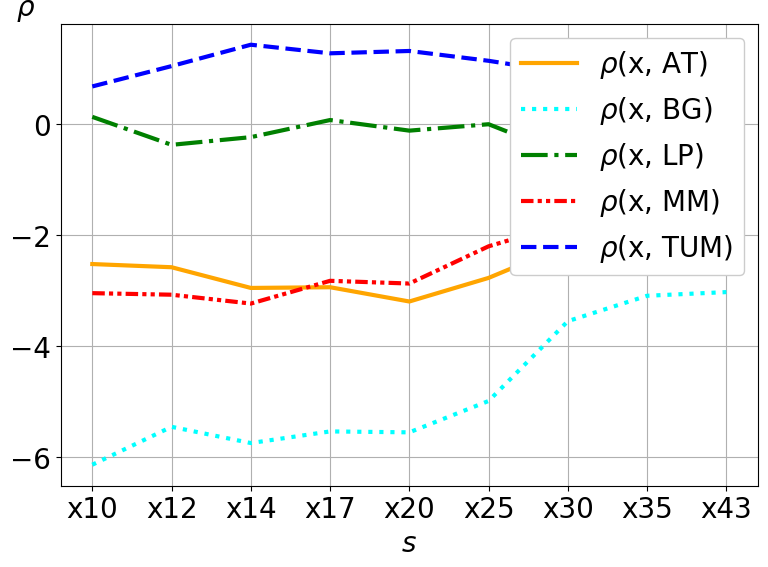

In [27]:
fig, ax = plt.subplots(figsize=(9,6))
for i in range(5):
    ax.plot(list(scales_dict.keys()), dot[:,i],
            label=r"$\rho$(x, {})".format(DEF_LABEL_FOLDER[i]),
            color=DEF_COLOR_MAP_NAME[i],
            linestyle=DEF_STYLE_MAP_NAME[i],
            linewidth=3.0)
ax.legend(loc="upper right", facecolor='white', framealpha=1)
ax.grid()
plt.ylabel(r"$\rho$", rotation=0)
plt.xlabel(r"$s$")
ax.yaxis.set_label_coords(-0.05, 1)
fig.savefig("out.png", bbox_inches='tight')

**Visualize an entire WSI image**

In [ ]:
slide_thimb_600 = slide.get_thumbnail(size=(600,600))

In [ ]:
np.array(slide_thimb_600).shape

In [ ]:
slide_annotated = cv2.imread(r"C:\Users\penki\Documents\cmc\data\PATH-DT-MSU-WSI\WSS2-v1\train\03_preview.jpg")
slide_annotated = cv2.cvtColor(slide_annotated, cv2.COLOR_BGR2RGB)

In [ ]:
slide.level_dimensions

In [ ]:
slide_annotated.shape

In [ ]:
plt.imshow(slide_annotated)

In [ ]:
plt.imshow(slide_annotated[250:1800, 2000:4200])

**AT (orange, 0) patch**

In [ ]:
plt.imshow(slide_annotated[400:400+224, 1800:1800+224])  # AT (0) 

In [ ]:
h_c = (400 + 400+224) // 2
w_c = (1800 + 1800+224) // 2

h_c, w_c

**BG (cyan, 1) patch**

In [ ]:
plt.imshow(slide_annotated[500:500+224, 450:450+224])  # BG (1) 

In [ ]:
h_c = (500 + 500+224) // 2
w_c = (450 + 450+224) // 2

h_c, w_c

**LP (green, 2) patch**

In [ ]:
plt.imshow(slide_annotated[300:300+224, 2700:2700+224])  # LP (2) 

In [ ]:
h_c = (300 + 300+224) // 2
w_c = (2700 + 2700+224) // 2

h_c, w_c

**MM (red, 3) patch**

In [ ]:
plt.imshow(slide_annotated[90:90+224, 2090:2090+224])  # MM (3) 

In [ ]:
h_c = (90 + 90+224) // 2
w_c = (2090 + 2090+224) // 2

h_c, w_c

**TUM (blue, 4) patch**

In [ ]:
plt.imshow(slide_annotated[1000:1000+224, 4050:4050+224])  # TUM (4) 

In [ ]:
h_c = (1000 + 1224) // 2
w_c = (4050 + 4050+224) // 2

h_c, w_c